# Timecourse with interactivity

## Interactivity

# Time course measurements

A shared understanding of how to interpret data from CFE systems would speed the development of measurements and standards towards improved reproducibility and address challenges in interpreting and comparing existing and future data, including data from failed experiments. Workshop participants agreed that time-course measurements of the product expressed in the CFE reaction should be favored over endpoint measurements, despite the time, labor, and costs involved, to obtain a more complete and informative view of a CFE reaction. Whenever possible, measurements should be reported as a reduced quantity, such as a mean value, with uncertainty (Figure 2A) and include a baseline from negative control measurements. Several recent studies have commented on metrics available from a time-course measurement of protein expression in a CFE workflow, for example, for the purpose of reaction optimization [ref] and the development of predictive modeling tools [ref]. Workshop participants emphasized several of these metrics, displayed below in Figure 2


- Maximum yield of product expressed;
- $t_{max}$ Time to reach the maximum yield of product expressed, as the time from the start of the measurement to the time to reach the maximum yield;
- $ v_{max}$ Maximum rate of product expression, as the maximum linear rate of production;
- Lag time, as the time from the start of the measurement to the time to reach the maximum rate of expression;
- Inflection time, as the time from the start of the measurement to the time at which the rate of product expression begins to decrease;
- Percent decline, as a decrease in the amount of product expressed from the maximum yield; and,
- Time to percent decline, as the amount of time from the start of the measurement to the time to reach a predefined decrease in the yield of product expressed after having reached its maximum yield of product expressed.

## Workflow

### Platemap

:::{note}
Ideally, we would have a tool that (1) let's people describe experiments in a standardized way (spec lang), (2) that can then be mapped onto a platemap, and (3) displayed in part or whole in this section [this might be an interesting place for a widget to explore the parameters of the experiment]
:::

This is text describing the context of the experiment. There a few scenarios where this text can end up here. We can imagine users working in jupyterhub typing directly or its copy and pasted in from an experimental notebook. In this particular case, we have two experiments on testing the effect of DNA concentration and a second experiment comparing different DNA constrcuts - the infamous artifact 11 (AR-11)

In [14]:
# import data.fusion_utils as utils
# import cdk.cytosol_utils as cytosol

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact

def read_platemap_tsv(platemap_path: str) -> pd.DataFrame:
    platemap = pd.read_table(platemap_path)

    platemap["Row"] = platemap["Well"].apply(lambda s: re.search(r"[A-Z]", s).group())
    platemap["Column"] = platemap["Well"].apply(lambda s: int(re.search(r"\d+", s).group()))
    platemap["Column"] = platemap["Column"].astype(int)

    return platemap

# LOAD YOUR PLATEMAP HERE"
platemap_path = "./sample-data/platemap.txt"
platemap = read_platemap_tsv(platemap_path)

# Create a dropdown widget to control the table
menu = widgets.Dropdown(
    options=['DNA Comparison', 'DNA Concentration'],
    value='DNA Concentration',
    description='Experiment:',
)

# Define a function that will plot a sine wave based on the frequency
def update_plot(exp_ID):
    # for cleaner visualization
    slx_platemap = platemap.set_index('Well', drop=True, inplace=False)
    show_platemap = slx_platemap[slx_platemap["Experiment"] == exp_ID].drop(columns=['Blank', 'Row', 'Column'])

    show_platemap_length = len(show_platemap)
    display(show_platemap.head(show_platemap_length))


# Use interact to connect the slider to the update_plot function
interact(update_plot, exp_ID=menu)
display()



interactive(children=(Dropdown(description='Experiment:', index=1, options=('DNA Comparison', 'DNA Concentrati…


 
::::{dropdown} See all experiments

:::{table} Experimental conditions studied
:label: tbl:platemap
![](#pd:platemap)
:::

::::

### Analysis

One thing that might be interesting to show here would be a progression from end-point analysis, unannotated timeseries, time series annotations, and then exploring the kinetic parameters. 

```{code} python
:label: code:filter-platemap
:caption: filter the plate map to select for a specific experiment
# experiment -> "DNA Concentration"
data_concentration = data[data["Experiment"] == "DNA Concentration"]
```

Here, [](#code:filter-platemap) is used to generate the following figure using these [specific lines](https://github.com/bnext-bio/nucleus/blob/main/cdk/analysis/cytosol-analysis/cytosol-kinetics.ipynb#L563-L565) of code from the cytosol analysis toolkit. This might be useful for instance if we're showcasing a new feature in the codebase and we want to make a tight connection between code and function, inviting engagement.

The immediate advantage of this notebook over our existing way of publishing is that the figure is unambiguously linked to the data and code used to generate it. In this particular case, the sample data is co-located in the directory used to generate the HTML. Another approach might be to pull the data programmatically from an archive like zenodo.

:::{admonition} Pulling data directly from an archive
:class: dropdown
```{code} python
# this workflow would also work for OSF
from zenodo_client import Zenodo

zenodo = Zenodo(access_token=token)
OOH_NA_NA_RECORD = '13852103'

platemap_file = '20240916-platemap.xlsx'
data_file = 'timecourse.csv'

data = zenodo.download_latest(OOH_NA_NA_RECORD, data_file)
platemap = zenodo.download_latest(OOH_NA_NA_RECORD, platemap_file)
```
:::

:::{figure} #plt:expression-kinetics-simple
:label: fig:expression kinetics
:align: center
The plasmid pT7-deGFP (AR-11) is swept from 0-100 ng/$\mu$L in the PURE system
:::

Now, we can showcase the kinetic analysis tool by showing a single timeseries selected from the above experiment where the extracted features are annotated. It was a bit annoying to extract one plot from the FacetGrid. Instead, I reduced the DataFrame

:::{admonition} Plotting a single annotated kinetic trace
:class: dropdown
```python
warnings.filterwarnings("ignore")

single_well = data_concentration[data_concentration["Well"] == "B1"]

single_well_kinetics = kinetic_analysis(data=single_well, data_column="Data", time_cutoff=15000)
g = sns.FacetGrid(single_well_kinetics, col="Well", col_wrap=2, sharey=False, height=4, aspect=1.5)
g.map_dataframe(plot_kinetics, y="Data", show_fit=True, show_velocity=False, annotate=True)
```
:::

:::{figure} #plt:single-kinetics
:label: fig:kinetics-plot
:align: center
Annotated timeseries for pT7-deGFP (AR-11) in PURE at a concentration of 100 ng/$\mu$L
:::

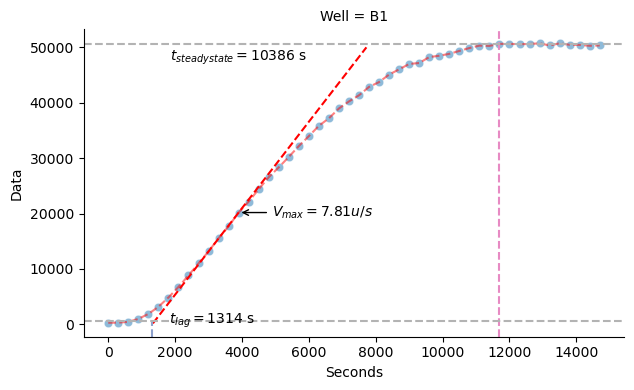

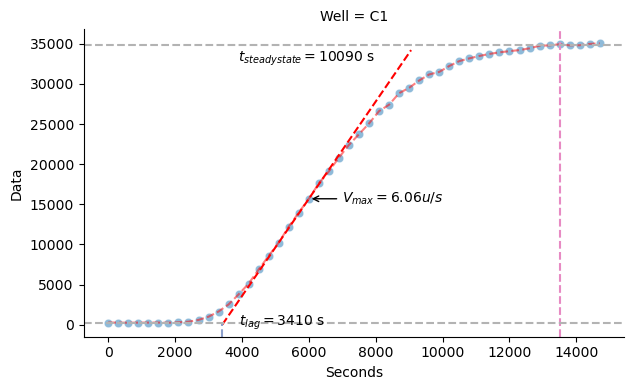

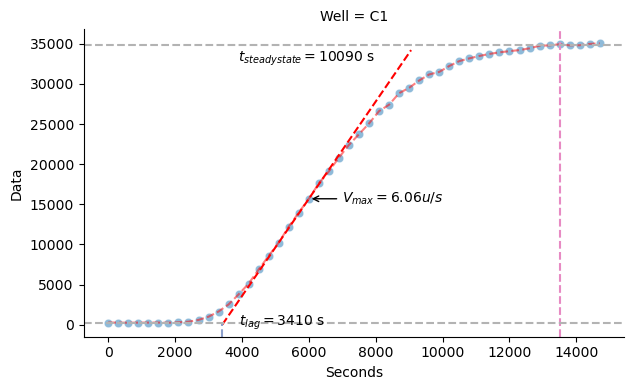

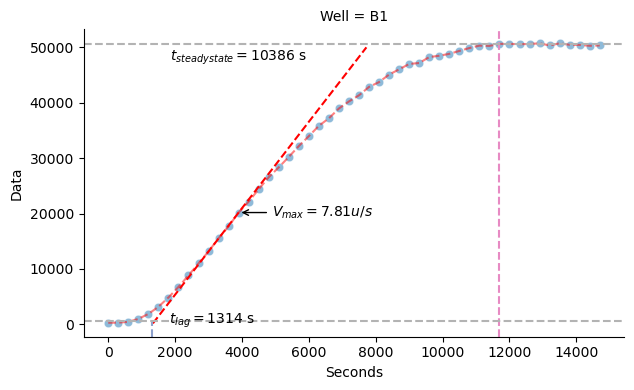

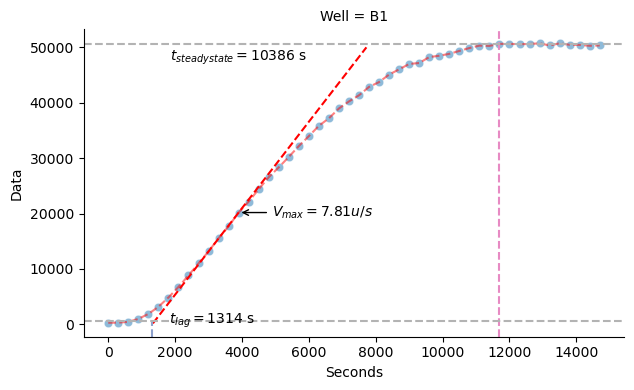

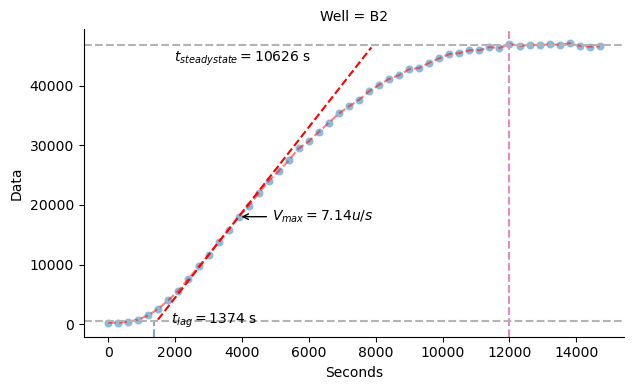

In [9]:
# Create a dropdown widget to control the table

# slx_platemap = platemap.set_index('Well', drop=True, inplace=False)
# show_platemap = slx_platemap[slx_platemap["Experiment"] == exp_ID].drop(columns=['Blank', 'Row', 'Column'])

exp_ID_list = platemap['Experiment'].drop_duplicates().tolist()

exp_wells_options = platemap.groupby('Experiment')['Well'].apply(list).to_dict()
# print(exp_wells_options.to_dict())
# display(exp_wells_options)

exp_menu = widgets.Dropdown(
    options=exp_ID_list,
    value='DNA Concentration',
    description='Experiment:',
)

well_menu = widgets.Dropdown(
    options=[],
    description='Options:'
)

def update_well_menu(change):
    selected_value = change['new']
    well_menu.options = exp_wells_options[selected_value]
    well_menu.value = well_menu.options[0]



def update_plot(Experiment, Well):

    # TODO: import data

    data = cytosol.read_cytation(
        datafile="./sample-data/pure-dna-sweep.txt",
        platemap=platemap,
    )

    data_by_experiment = data[data["Experiment"] == Experiment]
    data_by_well = data_by_experiment[data_by_experiment["Well"] == Well]

    single_well_kinetics = cytosol.kinetic_analysis(data=data_by_well, data_column="Data", time_cutoff=15000)
    g = sns.FacetGrid(single_well_kinetics, col="Well", col_wrap=2, sharey=False, height=4, aspect=1.5)
    g.map_dataframe(cytosol.plot_kinetics, y="Data", show_fit=True, show_velocity=False, annotate=True)

    plt.show()

# Callback function to update the plot when dropdowns change
def on_dropdown_change(change):
    Experiment = exp_menu.value
    Well = well_menu.value
    update_plot(Experiment, Well)

# Attach the callback function to the first dropdown
exp_menu.observe(update_well_menu, names='value')

# Attach the callback to both dropdowns
exp_menu.observe(on_dropdown_change, names='value')
well_menu.observe(on_dropdown_change, names='value')

# Arrange the widgets in a horizontal box
hbox = widgets.HBox([exp_menu, well_menu])

# Initialize the second dropdown options
update_well_menu({'new': exp_menu.value})

# Display the dropdowns and plot
hbox = widgets.HBox([exp_menu , well_menu])
display(hbox)

# Initial plot
# plot_sinusoid(frequency_dropdown.value, period_dropdown.value)


Of course, the figure isn't really what's valuable. Ultimately, we want to associate the dimension-reduced kinetic parameters with the experimental specification. We can push this to a database like SeqBase where the *input* sequence and experimental specification are coupled to the *output* kinetic parameters. 

Other types of data for non-fluorescent data will have to be developed over time. 

:::{table} Combined experimental specification with kinetic parameters extracted from data.
:label: tbl:platemap
:align: center
![](#pd:kinetics)
:::